In [14]:
import os
import subprocess
import chess
import re

In [15]:
def combine_adjacent_digits(s):
    def replacer(match):
        # Sum the digits instead of counting them
        return str(sum(int(digit) for digit in match.group()))

    return re.sub(r'\d+', replacer, s)

def five_to_eight(fen):
    fen = fen.replace("/", "3/")
    if ' ' in fen:
        fen = fen.split(' ')[0] + "3/8/8/8 " + fen.split(' ')[1]
    else:
        fen = fen + "3/8/8/8"
    fen = combine_adjacent_digits(fen)
    return fen

def add_start_pos_suffix(fen):
    return fen + ' w - - 0 1'

In [48]:
def uci_move_to_coords(uci_move):
    """Returns (a, b), (c, d) from a UCI string like e2e4"""
    col_to_int = {'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7}
    start_col, start_row, end_col, end_row = uci_move
    return (int(start_row) - 1, col_to_int[start_col]), ( int(end_row) - 1, col_to_int[end_col])

def move_to_squarescode(move_str):
    start_x, start_y = uci_move_to_coords(move_str)[0]
    end_x, end_y = uci_move_to_coords(move_str)[1]

    return 25 * (start_x * 5 + start_y) + (end_x * 5 + end_y)

move_to_squarescode('e2e4')

244

In [41]:
from data import load_from_json


def move_to_code(move, fen):
    """Only works for 5x5 board"""
    direction_map_king = {
        (-1, 0): 0, (-1, 1): 1, (0, 1): 2, (1, 1): 3,
        (1, 0): 4, (1, -1): 5, (0, -1): 6, (-1, -1): 7
    }

    def get_piece_at_coords(fen, pos):
        x, y = pos
        rows = fen.split('/')[::-1]
        target_row = rows[x]

        col_counter = 0
        for char in target_row:
            if char.isdigit():
                col_counter += int(char)
                if col_counter > y:
                    return None  # Empty square
            else:
                if col_counter == y:
                    return char  # Piece found
                col_counter += 1

        return None  # No piece at coordinate (e.g., if x, y is out of bounds)

    def uci_move_to_coords(uci_move):
        """Returns (a, b), (c, d) from a UCI string like e2e4"""
        col_to_int = {'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7}
        start_col, start_row, end_col, end_row = uci_move
        return (int(start_row) - 1, col_to_int[start_col]), ( int(end_row) - 1, col_to_int[end_col])

    (start_row, start_col), (end_row, end_col) = uci_move_to_coords(move)
    piece = get_piece_at_coords(fen, (start_row, start_col))

    if piece.upper() == 'K':
        return direction_map_king[(end_col - start_col, end_row - start_row)]
    elif piece.upper() == 'R':
        # Horizontal move
        if start_row == end_row:
            move_code = 8
            for col in range(5):
                if col == end_col:
                    return move_code
                if col != start_col:
                    move_code += 1
        # Vertical move
        else:
            move_code = 12
            for row in range(5):
                if row == end_row:
                    return move_code
                if row != start_row:
                    move_code += 1

d = load_from_json('training_data/mappings_size_5.json')
keys = list(d.keys())

for fen in keys[5000:5100]:
    move = d[fen]
    print(chess.Board(five_to_eight(fen)))
    print(fen, move, move_to_code(move, fen))

. . R . . . . .
. . . . . . . .
. . . . . . . .
k . . K . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
2R2/5/5/k2K1/5 d2c3 1
. . R . . . . .
. . . . . . . .
. . . . . . . .
. k . K . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
2R2/5/5/1k1K1/5 c5c3 14
. . R . . . . .
. . . . . . . .
. . . . . . . .
. . . K . . . .
k . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
2R2/5/5/3K1/k4 d2c2 0
. . R . . . . .
. . . . . . . .
. . . . . . . .
. . . K . . . .
. k . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
2R2/5/5/3K1/1k3 d2c3 1
. . . R . . . .
k . . . . . . .
. . . . . . . .
. . . K . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
3R1/k4/5/3K1/5 d2c3 1
. . . R . . . .
. k . . . . . .
. . . . . . . .
. . . K . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
3R1/1k3/5/3K1/5 d5d4 15
. . . R . . . .
. . k . . . . .
. . . . . . . .
. . . K . . . .
. . . . . . . .
. . . . . . . .

In [38]:
from data import save_to_json


d = load_from_json('training_data/mappings_size_5.json')
keys = list(d.keys())

vector_data = []
for fen in keys:
    move_code = move_to_code(d[fen], fen)
    int_list = fen_to_int_list(fen)
    vector_data.append((int_list, move_code))

save_to_json(vector_data, '_training_data/vectors_size_5.json')

In [55]:
from random import shuffle

shuffle(keys)
for key in keys[:100]:
    print(chess.Board(five_to_eight(key)))
    print(key, d[key])

. . . . . . . .
. . k . . . . .
. R . . . . . .
. . . . . . . .
. K . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
5/2k2/1R3/5/1K3 b1c2
. . . . . . . .
. . . . . . . .
. . . . k . . .
. R . . . . . .
. . . K . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
5/5/4k/1R3/3K1 b2d2
. K . . . . . .
. . . . . . . .
k . . . . . . .
. . . . . . . .
. . R . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
1K3/5/k4/5/2R2 c1c3
. . . . k . . .
. . . . . . . .
. . . . . . . .
K . . . . . . .
R . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
4k/5/5/K4/R4 a1d1
K . . . . . . .
. . . . . . . .
. k . . . . . .
. . . . R . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
K4/5/1k3/4R/5 e2e3
k . . . . . . .
. . . . . . . .
. . . . R . . .
. . . . . . . .
. K . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
k4/5/4R/5/1K3 e3b3
. . . . . . . .
. . R . . . . .
. K . . . . . .
. . . . . . . .
. . . . k . . .
. . . . . . . .
. . . . . . . .
. .

In [54]:
d = load_from_json('training_data/mappings_size_5.json')
keys = list(d.keys())

vector_data = []
for fen in keys:
    move_code = move_to_squarescode(d[fen])
    int_list = fen_to_piececode_list(fen)
    vector_data.append((int_list, move_code))

save_to_json(vector_data, 'training_data/squarecode_size_5.json')

In [ ]:

def square_to_coordinate(uci_square):
    col_to_int = {'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7}
    col, row = uci_square
    return col_to_int[col], int(row) - 1

def get_move_map(square, piece, board_size):
    direction_map_king = {
        (-1, 0): 0, (-1, -1): 1, (0, -1): 2, (1, -1): 3,
        (1, 0): 4, (1, 1): 5, (0, 1): 6, (-1, 1): 7
    }

    x, y = square_to_coordinate(square)
    if piece.upper() == 'K':
        return         

In [50]:
def fen_to_piececode_list(fen):
    """Only works on contextless FENs, i.e. the piece-positions only"""
    int_list = [0, 0, 0]
    for y, row in enumerate(fen.split('/')):
        x = 0
        for char in row:
            if char == 'K':
                int_list[0] = 5 * y + x
                x += 1
            elif char == 'R':
                int_list[1] = 5 * y + x
                x += 1
            elif char == 'k':
                int_list[2] = 5 * y + x
                x += 1
            else:
                # Assuming the character is a digit representing consecutive empty squares
                x += int(char)

    return int_list

In [53]:
fen_to_piececode_list('R3k/5/5/5/4K')

[24, 0, 4]

In [36]:
def fen_to_int_list(fen):
    """Only works on contextless FENs, i.e. the piece-positions only"""
    int_list = []
    for row in fen.split('/'):
        for char in row:
            if char == 'K':
                int_list.append(1)
            elif char == 'R':
                int_list.append(2)
            elif char == 'k':
                int_list.append(3)
            else:
                # Assuming the character is a digit representing consecutive empty squares
                int_list.extend([0] * int(char))

    return int_list

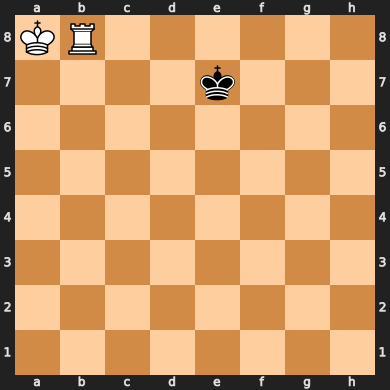

In [8]:
import chess
chess.Board(five_to_eight( 'KR3/4k/5/5/5 w - - 0 1'))